In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

from scipy.stats import multivariate_normal

from homework2 import GaussianMixture

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

K = 4

# import the results of the previous homework
gaussian_mixture = GaussianMixture(data_train.values, K, 'general', display='none')
gaussian_mixture.fit()

means, covs = gaussian_mixture.mus.T, gaussian_mixture.sigmas

In [3]:
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """
    Create a grid in the form of a list of points stored in a 2D array
    """

    if data is not None:
        xmax, xmin,  = np.max(data[:, 0]), np.min(data[:, 0])
        ymax, ymin = np.max(data[:, 1]), np.min(data[:, 1])
        
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1./step), 
                       np.arange(ymin, ymax, (ymax-ymin)*1./step))
    
    grid = np.c_[x.ravel(), y.ravel()]

    return grid, x, y

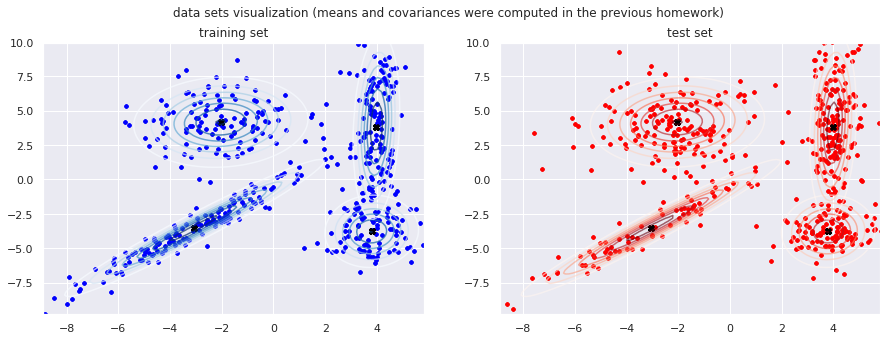

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('data sets visualization (means and covariances were computed in the previous homework)')

grid, x_grid, y_grid = make_grid(data=data_train.values, step=100)

ax1.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
ax1.set_title('training set')

for j in range(K):
    ax1.scatter(x=data_train.values[:, 0], y=data_train.values[:, 1], c='blue', marker='.')
    ax1.scatter(x=means[:, 0], y=means[:, 1], c='black', marker='X')
    ax1.contour(x_grid, y_grid, multivariate_normal.pdf(grid, mean=means[j],
                                                        cov=covs[j]).reshape(x_grid.shape),
                levels=None, alpha=0.7, linestyles='solid', cmap='Blues')
    
ax2.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
ax2.set_title('test set')

for j in range(K):
    ax2.scatter(x=data_test.values[:, 0], y=data_test.values[:, 1], c='red', marker='.')
    ax2.scatter(x=means[:, 0], y=means[:, 1], c='black', marker='X')
    ax2.contour(x_grid, y_grid, multivariate_normal.pdf(grid, mean=means[j],
                                                        cov=covs[j]).reshape(x_grid.shape),
                levels = None, alpha=0.6, linestyles='solid', cmap='Reds');

# Hidden Markov model

In [5]:
def log_sum_exp(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

def gaussian_log_pdf(x, mu, sigma):
    n = mu.size
    return - 0.5 * ((x - mu).dot(np.linalg.inv(sigma).dot(x - mu)) + n * np.log(2 * np.pi) + np.log(np.linalg.det(sigma)))

In [6]:
class GaussianHMM:
    """
    HMM class for gaussian emissions
    """
    
    def __init__(self, a, pi, mu, sigma, min_float=1e-50):
        assert(a.shape[0] == a.shape[1] == pi.shape[0] == mu.shape[0] == sigma.shape[0])
        self.num_states = a.shape[0]
        
        self.mu = mu
        self.sigma = sigma
        
        self.min_float = min_float
        self.log_a = np.log(a + min_float)
        self.log_pi = np.log(pi + min_float)
        
    # emission probabilities p(u_t|q_t=i)
    def log_f(self, u, i):
        return gaussian_log_pdf(u, self.mu[i], self.sigma[i])
    
    def log_likelihood(self, u):
        log_alpha, _, _, _ = self.forward_backward(u)
        return log_sum_exp(log_alpha[-1])
        
    def forward_backward(self, u):
        num_obs = u.shape[0]
        log_alpha = np.zeros((num_obs, self.num_states))
        log_beta = np.zeros((num_obs, self.num_states))
        
        # alpha recursion
        for t in range(num_obs):
            for i in range(self.num_states):
                if t == 0:
                    log_alpha[t, i] = self.log_pi[i] + self.log_f(u[0], i)
                else:
                    log_alpha[t, i] = log_sum_exp(log_alpha[t - 1, :] + self.log_a[:, i]) + self.log_f(u[t], i)
                
        # beta recursion
        for t in reversed(range(num_obs)):
            for i in range(self.num_states):
                if t == num_obs - 1:
                    log_beta[t, i] = 0.0
                else:
                    # array of p(u_t+1|q_t+1=j) for all j
                    p_emissions = np.array([self.log_f(u[t + 1], j) for j in range(self.num_states)])
                    
                    log_beta[t, i] = log_sum_exp(log_beta[t + 1, :] + self.log_a[i, :] + p_emissions)
                    
        # gamma and xi computation
        log_gamma = log_alpha + log_beta
        log_xi = np.zeros((num_obs - 1, self.num_states, self.num_states))
        
        for t in range(num_obs - 1):
            for i in range(self.num_states):
                for j in range(self.num_states):
                    log_xi[t, i, j] = log_alpha[t, i] + self.log_a[i, j] + log_beta[t + 1, j] + self.log_f(u[t + 1], j)
            
            log_gamma[t] -= log_sum_exp(log_alpha[t] + log_beta[t])
            log_xi[t] -= log_sum_exp(np.array([log_sum_exp(log_xi[t, i]) for i in range(self.num_states)]))
        
        return log_alpha, log_beta, log_gamma, log_xi
    
    def learn_parameters(self, u, tol, max_iter, verbose=False):
        """
        Expectation Maximization algorithm for HMM
        """
        
        num_obs = u.shape[0]
        
        former_log_likelihood = - np.inf
        for step in range(max_iter):
            
            # E step
            
            log_alpha, log_beta, log_gamma, log_xi = self.forward_backward(u)
            gamma = np.exp(log_gamma)
            xi = np.exp(log_xi)
            
            log_likelihood = log_sum_exp(log_alpha[-1])
            if verbose:
                print('step: {}, log likelihood: {}'.format(step, log_likelihood))
            
            # convergence check
            assert(former_log_likelihood <= log_likelihood)
            if abs(log_likelihood - former_log_likelihood) < tol:
                break
                
            former_log_likelihood = log_likelihood
            
            # M step
            
            # initial probability update
            self.log_pi = log_alpha[0] + log_beta[0]
            self.log_pi -= log_sum_exp(self.log_pi)
            
            # transition probabilities update
            for i in range(self.num_states):
                for j in range(self.num_states):
                    self.log_a[i, j] = log_sum_exp(log_xi[:, i, j]) - log_sum_exp(log_gamma[:-1, i])

            # means update
            for i in range(self.num_states):
                self.mu[i] = np.sum(gamma[:, i, np.newaxis] * u, axis=0) / np.sum(gamma[:, i])

           # covariance matrices update
            for i in range(self.num_states):
                cov_array = np.array([gamma[t, i] * np.outer(u[t] - self.mu[i], u[t] - self.mu[i]) 
                                      for t in range(num_obs)])
                self.sigma[i] = np.sum(cov_array, axis=0) / np.sum(gamma[:, i])
                    
    def decode(self, u):
        """
        Viterbi algorithm for decoding
        """
        
        num_obs = u.shape[0]
        log_v = np.zeros((num_obs, self.num_states))
        s = np.zeros(num_obs)
        
        for i in range(self.num_states):
            log_v[0, i] = self.log_pi[i] + self.log_f(u[0], i)
            
        for t in range(1, num_obs):
            for i in range(self.num_states):
                best_j = np.argmax(log_v[t - 1] + self.log_a[:, i])
                log_v[t, i] = log_v[t - 1, best_j] + self.log_a[best_j, i] + self.log_f(u[t], i)
                s[t - 1] = best_j
                
        s[num_obs - 1] = np.argmax(log_v[t - 1])
        
        return s

In [7]:
def initialize_random_parameters():
    # transition matrix
    a = np.random.rand(K, K)
    for i in range(K):
        a[i] *= 1 / np.sum(a[i])
    
    # initial probability
    pi = np.random.rand(K)
    pi *= 1 / np.sum(pi)
    return a, pi

## Parameters learning

In [8]:
a, pi = initialize_random_parameters()
mu = np.copy(means)
sigma = np.copy(covs)
gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
gaussian_hmm.learn_parameters(data_train.values, tol=1e-5, max_iter=100, verbose=True)

step: 0, log likelihood: -2519.602884705921
step: 1, log likelihood: -1925.4075068131503
step: 2, log likelihood: -1900.1530600253866
step: 3, log likelihood: -1897.2132653680133
step: 4, log likelihood: -1896.8509896327198
step: 5, log likelihood: -1896.8007148580102
step: 6, log likelihood: -1896.7935747043718
step: 7, log likelihood: -1896.7925816846578
step: 8, log likelihood: -1896.7924447649555
step: 9, log likelihood: -1896.7924258222015
step: 10, log likelihood: -1896.7924231573645


## Comparing HMM and GMM

In [9]:
# computing the sequence of more likely states for HMM and GMM on both datasets
hmm_train_states = gaussian_hmm.decode(data_train.values).astype('int')
hmm_test_states = gaussian_hmm.decode(data_test.values).astype('int')

gmm_train_states = gaussian_mixture.predict(data_train.values).astype('int')
gmm_test_states = gaussian_mixture.predict(data_test.values).astype('int')

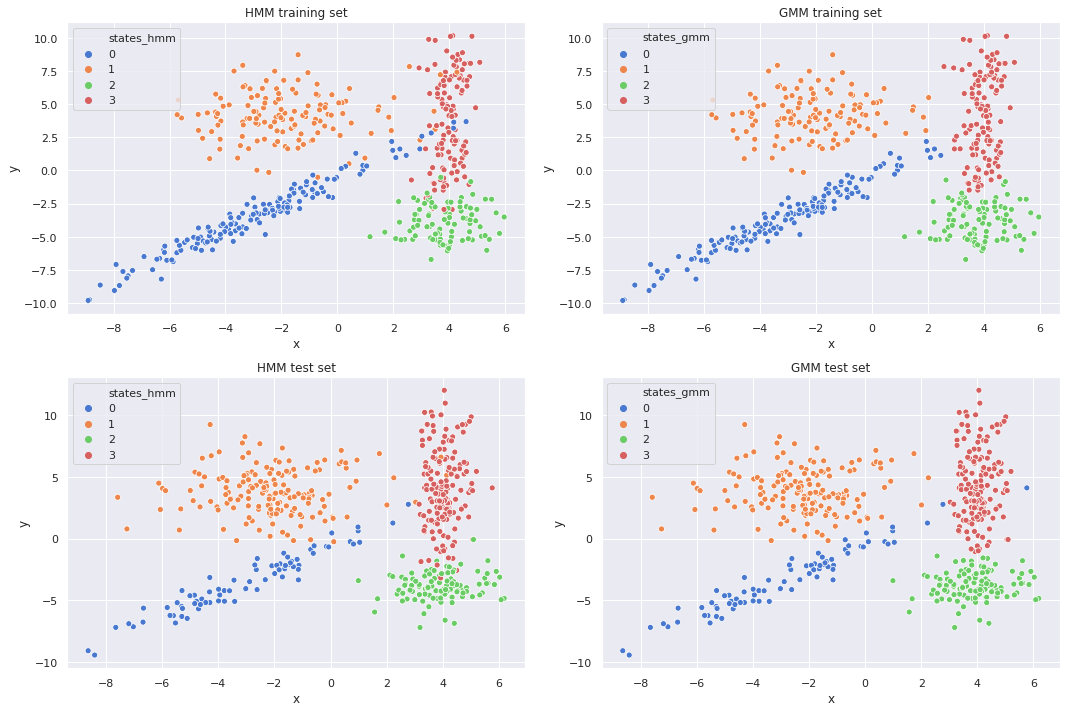

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_title('HMM training set')
ax2.set_title('GMM training set')

data_train_copy = data_train.copy()

data_train_copy['states_hmm'] = pd.Series(hmm_train_states)
data_train_copy['states_gmm'] = pd.Series(gmm_train_states)

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax1)

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax2)

ax3.set_title('HMM test set')
ax4.set_title('GMM test set')

data_test_copy = data_test.copy()

data_test_copy['states_hmm'] = pd.Series(hmm_test_states)
data_test_copy['states_gmm'] = pd.Series(gmm_test_states)

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax3)

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax4)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

fig.tight_layout();

In [11]:
print('HMM log likelihood (training set) : {0:.2f}'.format(gaussian_hmm.log_likelihood(data_train.values)))
print('HMM log likelihood (test set) : {0:.2f}'.format(gaussian_hmm.log_likelihood(data_test.values)))
print()

gaussian_mixture.predict(data_train.values)
print('GMM log likelihood (training set) : {0:.2f}'.format(gaussian_mixture.jfunc()))
gaussian_mixture.predict(data_test.values)
print('GMM log likelihood (test set) : {0:.2f}'.format(gaussian_mixture.jfunc()))

HMM log likelihood (training set) : -1896.79
HMM log likelihood (test set) : -1955.17

GMM log likelihood (training set) : -2327.74
GMM log likelihood (test set) : -2409.25


## Influence of the initialization

In [12]:
n_test = 10
mus = np.zeros((n_test, *means.shape))
sigmas = np.zeros((n_test, *covs.shape))
logas  =   np.zeros((n_test, *a.shape))
logpis = np.zeros((n_test, *pi.shape))

for step in range(n_test):
    mu = np.copy(means)
    sigma = np.copy(covs)
    a, pi = initialize_random_parameters()
    gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
    gaussian_hmm.learn_parameters(data_train.values, tol=1e-5, max_iter=100, verbose=False)
    
    mus[step] = gaussian_hmm.mu
    sigmas[step] = gaussian_hmm.sigma
    logas[step] = gaussian_hmm.log_a
    logpis[step] = gaussian_hmm.log_pi

In [13]:
print(mus.std(axis=0)/mus.mean(axis=0))

[[-9.65973391e-08 -8.77198570e-08]
 [-2.71367704e-06  5.95772179e-07]
 [ 9.33147409e-07 -9.90158516e-06]
 [ 2.46074908e-07  1.68705114e-05]]


In [14]:
print(sigmas.std(axis=0)/sigmas.mean(axis=0))

[[[2.51898583e-07 2.72766756e-07]
  [2.72766756e-07 2.85192961e-07]]

 [[8.04991599e-06 4.50675836e-05]
  [4.50675836e-05 1.85497550e-06]]

 [[9.75590935e-06 1.13287121e-04]
  [1.13287121e-04 6.22056665e-05]]

 [[1.02659380e-05 1.71587725e-05]
  [1.71587725e-05 1.64018138e-05]]]


In [15]:
print(logas.std(axis=0)/logas.mean(axis=0))

[[-3.41982688e-07 -9.99571110e-07 -8.61448379e-06 -3.46685697e-06]
 [-3.68121189e-07 -4.05344095e-07 -4.28981447e-05 -5.21923696e-05]
 [-3.94634559e-06 -6.85874312e-05 -1.13487340e-05 -5.56467931e-05]
 [-2.74080538e-06 -7.56642924e-05 -8.97387985e-05 -3.09245581e-05]]


In [16]:
print(logpis.std(axis=0)/logpis.mean(axis=0))

[-1.22474487 -0.0745093  -0.08429623 -0.07076888]


## Influence of shuffling the data

In [17]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

In [18]:
a, pi = initialize_random_parameters()
mu = np.copy(means)
sigma = np.copy(covs)
gaussian_hmm = GaussianHMM(a, pi, mu, sigma)
gaussian_hmm.learn_parameters(data_train.values, tol=1e-5, max_iter=100, verbose=True)

step: 0, log likelihood: -2427.0911012865945
step: 1, log likelihood: -2321.004490320405
step: 2, log likelihood: -2320.3789959287055
step: 3, log likelihood: -2320.293840274044
step: 4, log likelihood: -2320.2715012223152
step: 5, log likelihood: -2320.259951716504
step: 6, log likelihood: -2320.251630558819
step: 7, log likelihood: -2320.2450021553013
step: 8, log likelihood: -2320.2395658277956
step: 9, log likelihood: -2320.235062115322
step: 10, log likelihood: -2320.231313950197
step: 11, log likelihood: -2320.2281858419788
step: 12, log likelihood: -2320.225569660603
step: 13, log likelihood: -2320.2233776880926
step: 14, log likelihood: -2320.2215382138297
step: 15, log likelihood: -2320.219992335085
step: 16, log likelihood: -2320.218691495695
step: 17, log likelihood: -2320.2175955474077
step: 18, log likelihood: -2320.2166712054022
step: 19, log likelihood: -2320.21589080896
step: 20, log likelihood: -2320.2152313217352
step: 21, log likelihood: -2320.21467352137
step: 22, l

In [19]:
# computing the sequence of more likely states for HMM and GMM on both datasets
hmm_train_states = gaussian_hmm.decode(data_train.values).astype('int')
hmm_test_states = gaussian_hmm.decode(data_test.values).astype('int')

gmm_train_states = gaussian_mixture.predict(data_train.values).astype('int')
gmm_test_states = gaussian_mixture.predict(data_test.values).astype('int')

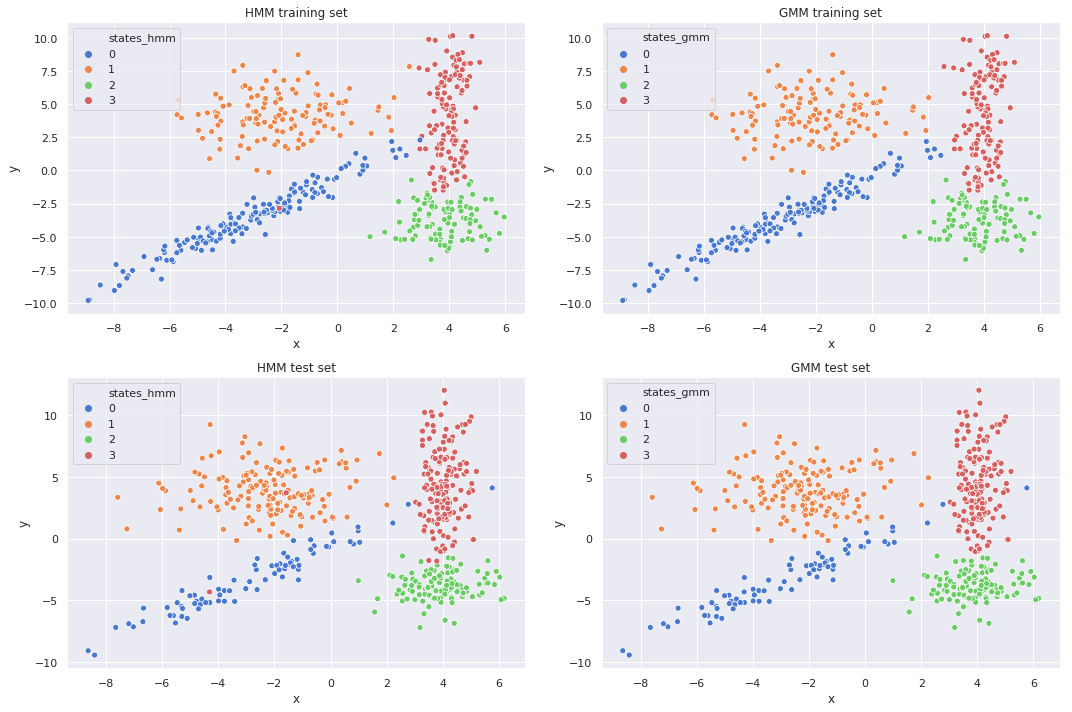

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_title('HMM training set')
ax2.set_title('GMM training set')

data_train_copy = data_train.copy()

data_train_copy['states_hmm'] = pd.Series(hmm_train_states)
data_train_copy['states_gmm'] = pd.Series(gmm_train_states)

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax1)

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax2)

ax3.set_title('HMM test set')
ax4.set_title('GMM test set')

data_test_copy = data_test.copy()

data_test_copy['states_hmm'] = pd.Series(hmm_test_states)
data_test_copy['states_gmm'] = pd.Series(gmm_test_states)

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax3)

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax4)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

fig.tight_layout();

In [21]:
print('HMM log likelihood (training set) : {0:.2f}'.format(gaussian_hmm.log_likelihood(data_train.values)))
print('HMM log likelihood (test set) : {0:.2f}'.format(gaussian_hmm.log_likelihood(data_test.values)))
print()

gaussian_mixture.predict(data_train.values)
print('GMM log likelihood (training set) : {0:.2f}'.format(gaussian_mixture.jfunc()))
gaussian_mixture.predict(data_test.values)
print('GMM log likelihood (test set) : {0:.2f}'.format(gaussian_mixture.jfunc()))

HMM log likelihood (training set) : -2320.21
HMM log likelihood (test set) : -2572.75

GMM log likelihood (training set) : -2327.74
GMM log likelihood (test set) : -2409.25
